<a href="https://colab.research.google.com/github/LionelAgo/Vortex_AE/blob/master/Vortex_Markov_chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages + Drive

1 - Install necessary package

2 - Import packages

3- mount drive

In [0]:
# - 2
#from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import h5py



# check tensorflow version, we want the one that support eager mode
tf.__version__

'1.14.0'

In [0]:
# - 3
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive/Colab Notebooks"
import os
dir="/content/drive/My Drive/Colab Notebooks/Vortex/"
os.chdir(dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load Jet data + Preprocessing

## Load data 
Data avaible: 
https://app.box.com/s/24wakswab2di53eu2l9wx6e65nf4nn2x

In [0]:
hf = h5py.File('U.h5', 'r')
U = hf.get('U')
U = np.array(U)
hf.close()
print(f'data downloaded')


data downloaded


##  Prepare Data for Autoencoder 


1.  **Feature scaling**

       - MinMaxScaler -> speed up training process (last layer: sigmoid)
2.  **build matrice with temporal shift for embbeded the dynamic** 
      - CNN with conv3d      
2. **Split the Data for training and validation**
      - multiple of 128 ( memory optimisation for TPU)
      - Temporel shift can be introduced between the input and ouput for reinforce the dynamic in Latent space


       
       





In [0]:
# - 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01, 0.99))

def scaleC(tmp='U'):
  nt,nx,nz=np.shape(tmp)
  tmp=np.reshape(tmp,(nt,nx*nz))
  tmp=scaler.fit_transform(tmp.T)
  tmp=tmp.T
  tmp=np.reshape(tmp,(nt,nx,nz,1))
  #tmp=np.expand_dims(tmp,axis=4)
  tmp=tmp[:,2:-2,2:,:]
  return tmp

U=scaleC(U)
#V=scaleC(V)
#Om=scaleC(Om)
#S=scaleC(S)
print(f'Database size_{np.shape(U)}')

Database size_(501, 256, 88, 1)


In [0]:

# - 2
def data4AE3d(v,dt=8):

  nt,nx,nz,nc=np.shape(v) 
  for i in np.arange(0,dt):
    t=v[i:int(nt-dt+i),:,:,:]
    t=np.expand_dims(t,1)
    if i==0:
      tmp=t
    else:
      tmp=np.concatenate((tmp,t),axis=1)
  return tmp  

dt=12
Ut=data4AE3d(U,dt)


In [0]:
# - 3
tshift=0
Utrain_1 = Ut[0:int(1*128),:,:,:,:].astype(np.float32)
Utrain_2 = Ut[tshift:int(tshift+1*128),:,:,:,:].astype(np.float32)

# Auto - encoder

## Encoding - Decoding

**dimensionality reduction:**
- Encoder --> Latent space (Zenc)
---

In [0]:
# if k=1 compile, else  load data
def Zenc_def(k=2):
  if k==1:
    X1=Ut[:,:,:,:,:].astype(np.float32)
    Zenc = encoder.predict(X1)
    print(f'size_of_latent_dim_{np.shape(Zenc)}')
    hf = h5py.File('Zenc_F64.h5', 'w')
    hf.create_dataset('Zenc', data=Zenc, compression='gzip')
    hf.close()   
  else:
    hf = h5py.File('Zenc_F64.h5', 'r')
    n1 = hf.get('Zenc')
    Zenc = np.array(n1)
    hf.close()
  return Zenc  

Zenc=Zenc_def()  

**Reconstruct:**
 - Latent space --> Decoder (Renc)
---


In [0]:
# if k=1 compile, else  load data
def Renc_def(k=2):
  if 1==2:
    import time
    start = time.process_time()
    Renc=decoder.predict(Zenc[:,:])
    print(f'size_of_reconstructed_field_{np.shape(Renc)}')
    print(time.process_time() - start)
    Renc=np.squeeze(Renc[:,0,:,:,0])
    hf = h5py.File('Renc_F64.h5', 'w')
    hf.create_dataset('Renc', data=Renc, compression='gzip')
    hf.close() 
  else:
    hf = h5py.File('Renc_F64.h5', 'r')
    n1 = hf.get('Renc')
    Renc = np.array(n1)
    hf.close()
  return Renc

Renc=Renc_def()      

#Clustering in Latent space

In [0]:
#function plot fields reconstruct from clusters

def draw_modes(u,nc,pred,nc_proj=3,plot_mode=0):
  c='Set1'
  c='tab10'
  
  
  if nc_proj==3:
    fig = plt.figure(figsize=(27, 9))
    ax = fig.add_subplot(131, projection='3d')
    #ax.scatter(u[:,0], u[:,1], u[:,2], s=1, c=pred, cmap=c)
    ax.scatter(u[pred !=-1,0], u[pred !=-1,1], u[pred !=-1,2], s=1, c=pred[pred !=-1], cmap=c)
  
    ax = fig.add_subplot(132, projection='3d')
    #ax.scatter(u[:,1], u[:,2], u[:,0], s=1, c=pred, cmap=c)
    ax.scatter(u[pred !=-1,1], u[pred !=-1,2], u[pred !=-1,0], s=1, c=pred[pred !=-1], cmap=c)

      
    ax = fig.add_subplot(133, projection='3d')
    #pp=ax.scatter(u[:,2], u[:,0], u[p:,1], s=1, c=pred, cmap=c)
    pp=ax.scatter(u[pred !=-1,2], u[pred !=-1,0], u[pred !=-1,1], s=1, c=pred[pred !=-1], cmap=c)

    
    fig.colorbar(pp, orientation='horizontal')
  else:
    fig = plt.figure(figsize=(9, 9))
    pp=plt.scatter(u[pred !=-1,0], u[pred !=-1,1], s=1, c=pred[pred !=-1], cmap=c)
    fig.colorbar(pp, orientation='horizontal')

  if plot_mode==1:
    f, ax = plt.subplots(int(nc/2+0.5), 2, sharey=True,figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

    ix=0
    for row in ax:
      for col in row:
          C=decoder.predict(Zenc[pred==ix])
          C=np.mean(C, axis=0)
          zmin=C.min()
          zmax=C.max()
          col.imshow(np.squeeze(C[0,:,:,0]), cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='equal', origin='low')
          ix+=1
    print(ix)
      


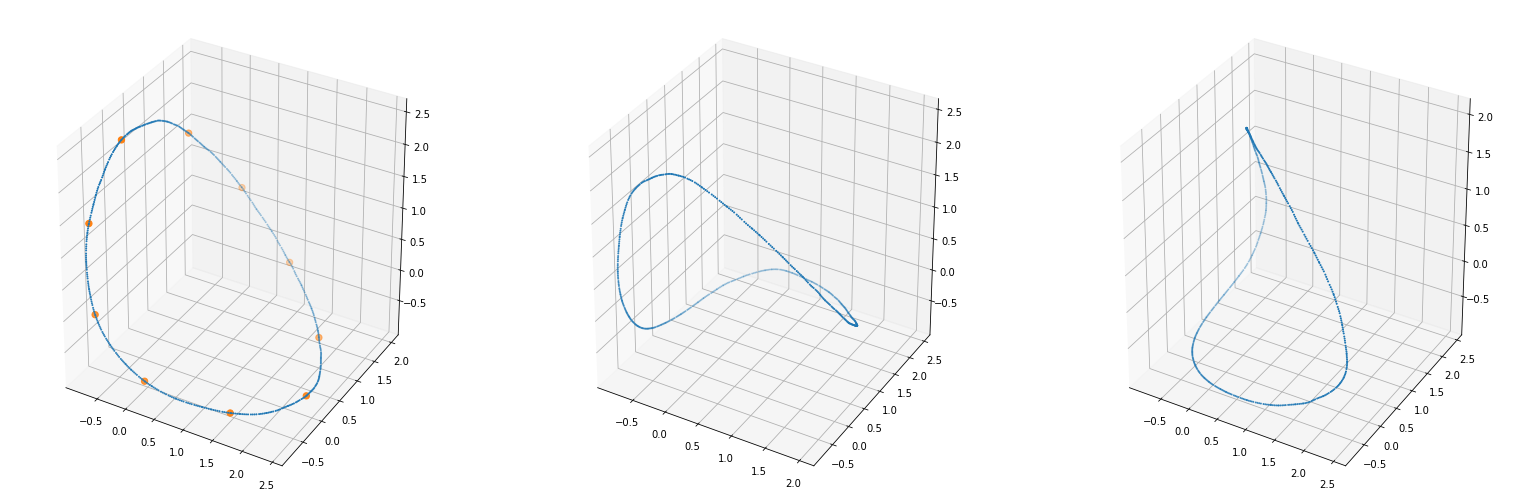

In [0]:
from mpl_toolkits.mplot3d import Axes3D
u=Zenc
fig = plt.figure(figsize=(27, 9))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(u[:,0], u[:,1], u[:,2], s=1)
k=10
ax.scatter(u[:k,0], u[:k,1], u[:k,2], s=40)
  
ax = fig.add_subplot(132, projection='3d')
ax.scatter(u[:,1], u[:,2], u[:,0], s=1)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(u[:,2], u[:,0], u[:,1], s=1)


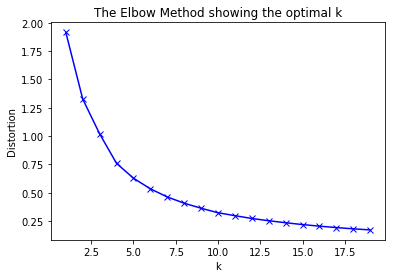

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,20)
for k in K:
   
    km = KMeans(init='k-means++',n_clusters=k, random_state=10)
    pred_km= km.fit_predict(u)

    distortions.append(sum(np.min(cdist(u, km.cluster_centers_, 'euclidean'), axis=1)) / u.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [0]:
#@title number of cluster
nc = 8 #@param {type:"slider", min:0, max:20, step:1}

from sklearn.cluster import KMeans,SpectralClustering



km = KMeans(init='k-means++',n_clusters=nc, random_state=100)
pred_km= km.fit_predict(Zenc)

sm = SpectralClustering(n_clusters=nc, affinity='nearest_neighbors', assign_labels='kmeans')
pred_sm = sm.fit_predict(Zenc)




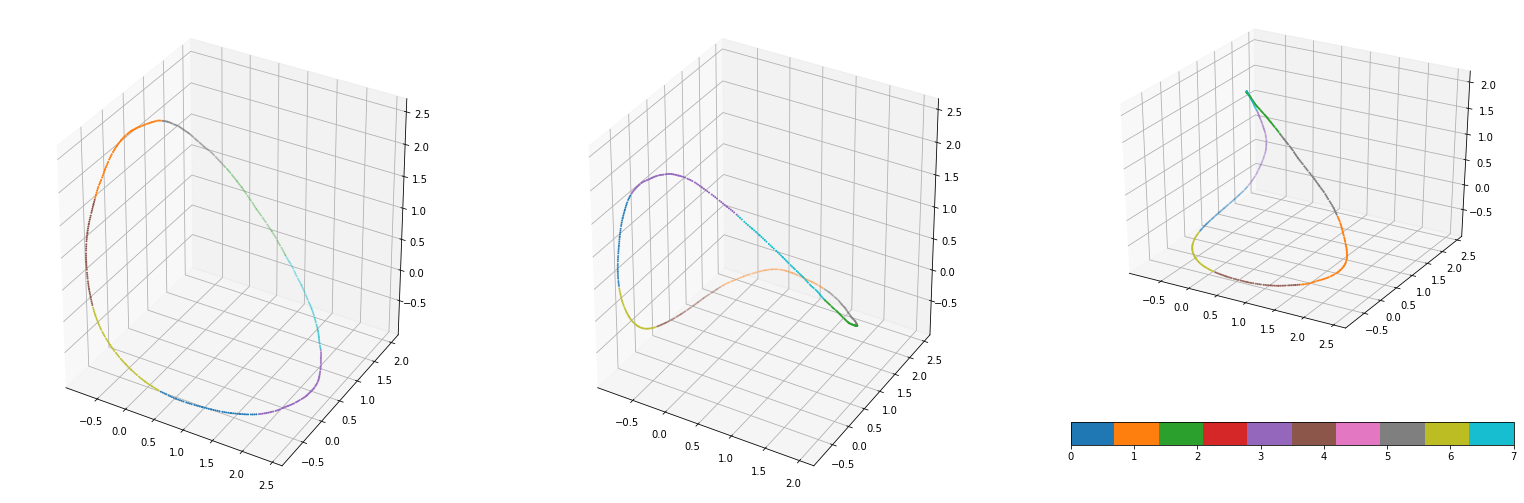

In [0]:
draw_modes(u,nc,pred_km)

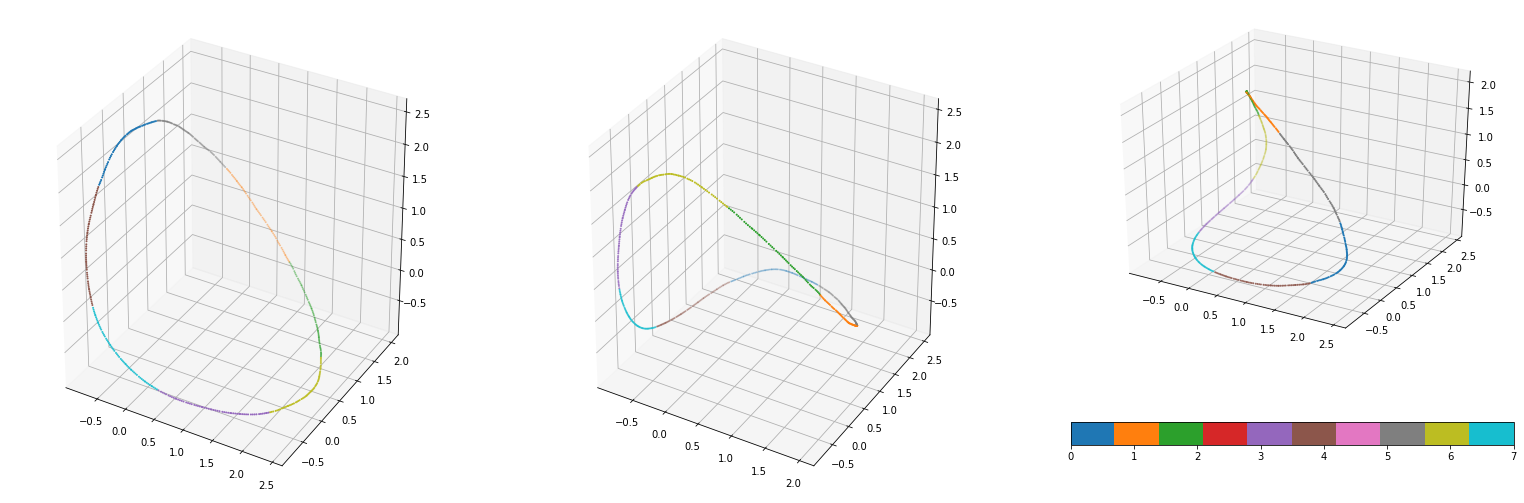

In [0]:
draw_modes(u,nc,pred_sm)

# Graph of Markov Chain

## Probabily by State

<BarContainer object of 8 artists>

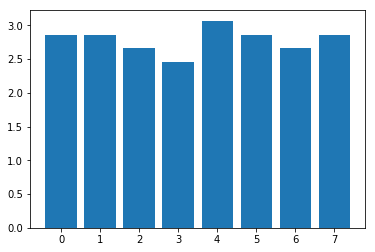

In [0]:
#pred=pred_hdb[pred_hdb>-1]
pred=pred_sm

H, xedges, yedges = np.histogram2d(pred[0:-1], pred[1:],bins=(nc))

nt=489
H=H*100/nt
ns=np.diag(H)

plt.bar(np.arange(0,nc),ns)



## Probability and trajectories between state 

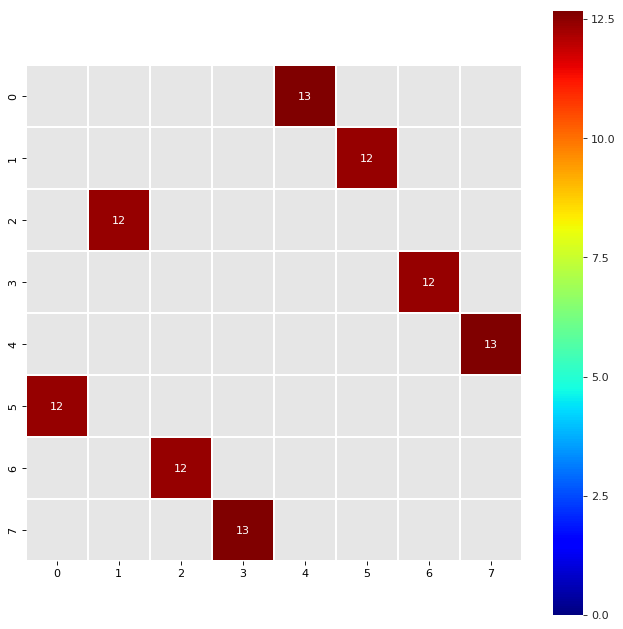

In [0]:
import seaborn as sns
Ht=H
np.fill_diagonal(Ht,0)
Ht=100*Ht/np.sum(Ht)

_, ax = plt.subplots(1, 1, sharey=True,figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
zmax=Ht.max()


#with sns.axes_style("white"):
#    ax = sns.heatmap(H,  annot=True, vmin=0, vmax=zmax, square=True, cmap="seismic", linewidths=.5)



mask = np.zeros_like(Ht)
mask[np.diag_indices_from(mask)] = True
A=np.round(Ht,1)
A[A<1.5]=0
mask[np.where(A==0)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Ht, mask=mask,  annot=True,  square=True, cmap="jet", linewidths=.5)
    ax.set_facecolor((0.9,0.9,0.9))

## Graph and States

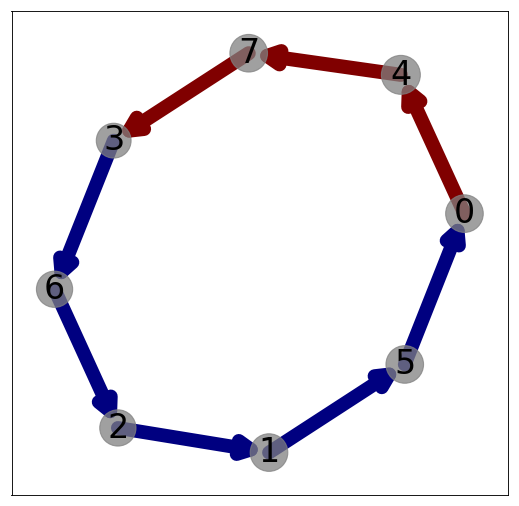

In [0]:
import networkx as nx
temp=nx.MultiDiGraph()


G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)


_, ax = plt.subplots(1, 1, sharey=True,figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

H, xedges, yedges = np.histogram2d(pred[0:-1], pred[1:],bins=(nc))
H=H*100/nt
ns=np.diag(H)

layout = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos=layout, node_size=400*ns, alpha=0.75, node_color='gray')
nx.draw_networkx_labels(G, pos=layout, font_size=30, font_family='sans-serif')

epline=np.reshape(A,np.size(A))
epline=epline[epline>0]


edges = nx.draw_networkx_edges(G, pos=layout, node_size=10*ns, linestyle='.', arrowstyle='-|>',
                               arrowsize=30,  edge_color=epline,edge_alphas=0.75,
                               edge_cmap=plt.cm.jet, 
                               width=epline)

plt.savefig('graph.png')

plt.savefig('graph.eps', format='eps')



      


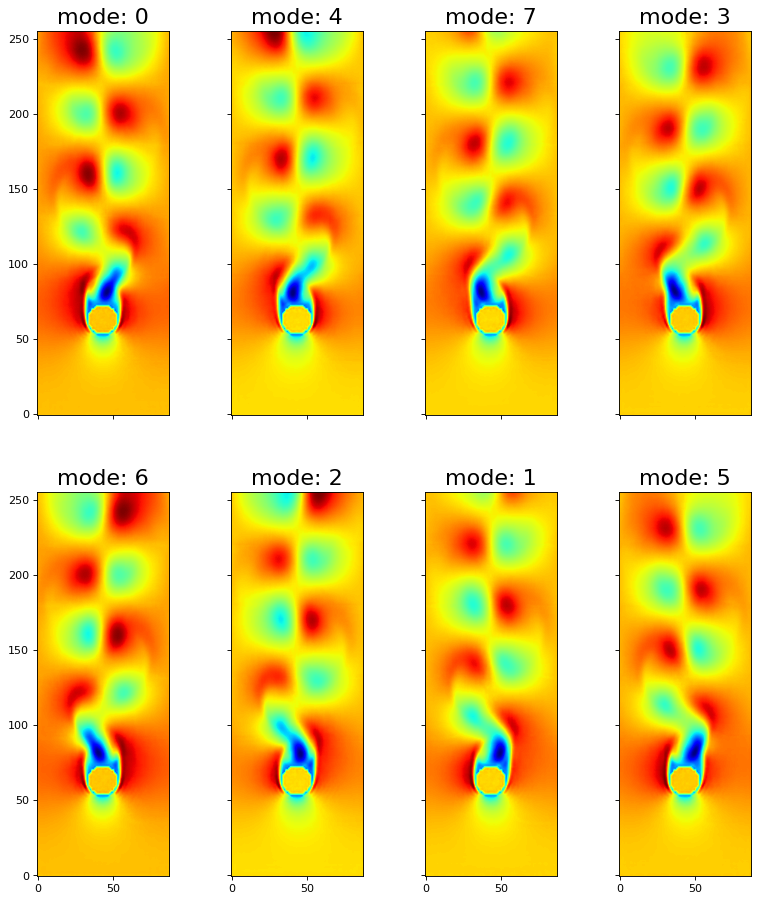

In [0]:
f, ax = plt.subplots(int(nc/4+0.5), 4, figsize=(12,14), dpi=80, facecolor='w', edgecolor='k',sharex='col', sharey='row')

order=np.array((0,4,7,3,6,2,1,5))

ix=0
for row in ax:
    for col in row:
      ii=order[ix]
      #C=decoder.predict(Zenc[pred_sm==ix])
      C=Renc[pred_sm==ii,:,:]
      C=np.mean(C, axis=0)
      zmin=C.min()
      zmax=C.max()
      #col.imshow(np.squeeze(C[0,:,:,0]), cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='equal', origin='low')
      col.imshow(C, cmap='jet', vmin=zmin, vmax=zmax ,interpolation='spline16', aspect='equal', origin='low')
      col.set_title('mode: %i' %ii , fontsize=20)
      ix+=1

plt.savefig('Modes.png')
plt.savefig('Modes.eps', format='eps')


## Final visualisation

(-0.5, 959.5, 1119.5, -0.5)

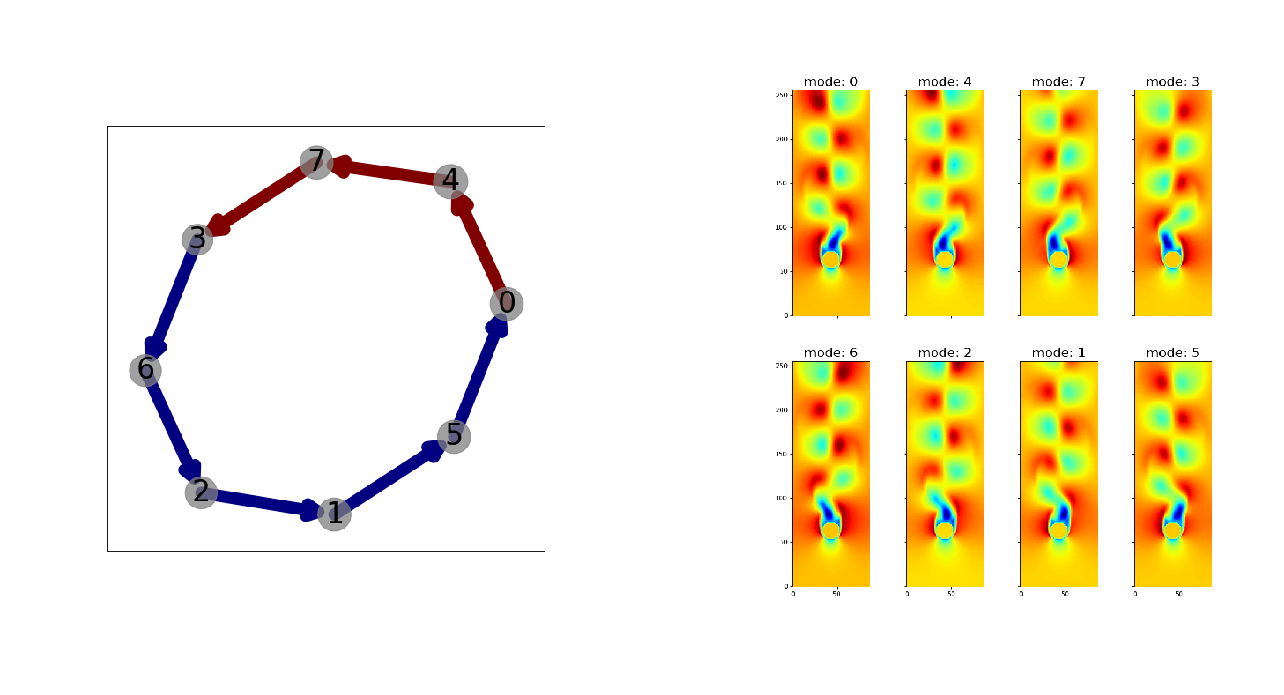

In [0]:
from IPython.display import Image, display
import matplotlib.image as mpimg
from matplotlib import rcParams


img_A = mpimg.imread('graph.png')
img_B = mpimg.imread('Modes.png')

# display images
fig, ax = plt.subplots(1,2,figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
ax[0].imshow(img_A);
ax[0].axis('off')

ax[1].imshow(img_B);
ax[1].axis('off')

#for img in [img_A, img_B]:
#    display(Image(filename = img))

# Others Clusters methods

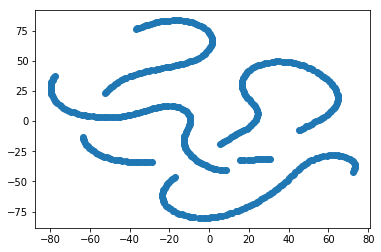

In [0]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=4.0, random_state=10)
X_tsne = tsne.fit_transform(Zenc)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],)
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2])
plt.show()



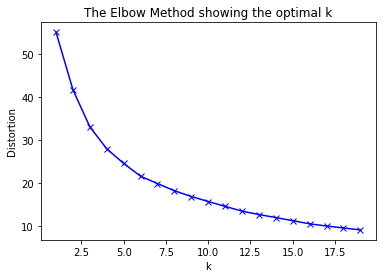

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
u=X_tsne
# k means determine k
distortions = []
K = range(1,20)
for k in K:
   
    km = KMeans(init='k-means++',n_clusters=k, random_state=100)
    pred_km= km.fit_predict(u)
    distortions.append(sum(np.min(cdist(u, km.cluster_centers_, 'euclidean'), axis=1)) / u.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [0]:

from sklearn.cluster import KMeans,SpectralClustering

nc=6

km = KMeans(init='k-means++',n_clusters=nc, random_state=10)
pred_km= km.fit_predict(u)

sm = SpectralClustering(n_clusters=nc, affinity='nearest_neighbors', assign_labels='kmeans')
pred_sm = sm.fit_predict(u)




/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


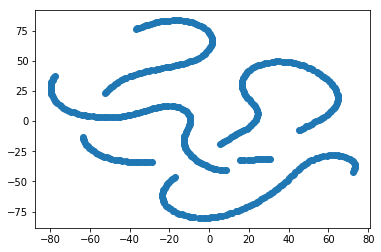

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], cmap=pred_km)
#draw_modes(Zenc,nc,pred_km)

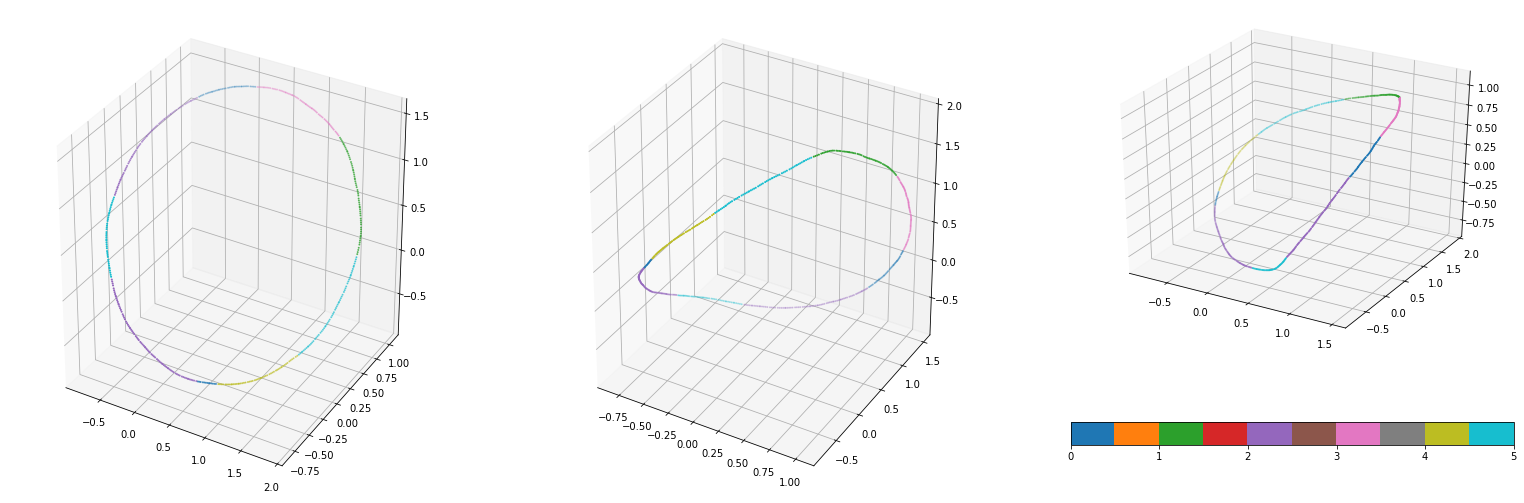

In [0]:
draw_modes(Zenc,nc,pred_sm)